In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import datetime
import os
import pickle
import scipy
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import skies


In [3]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)


output_path='./runs/2022_10_13_07_29_43'
Read: western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: cascadia.msh
Magnitude overview:
Maximum moment magnitude of entire mesh = 10.61
Maximum moment magnitude of single mesh element = 6.90
Minimum moment magnitude of single mesh element = 5.52
Maximum allowed moment magnitude = 9.00
Minimum allowed moment magnitude = 7.00
Maximum moment magnitude of entire mesh (10.61) exceeds MAXIMUM_EVENT_MOMENT_MAGNITUDE


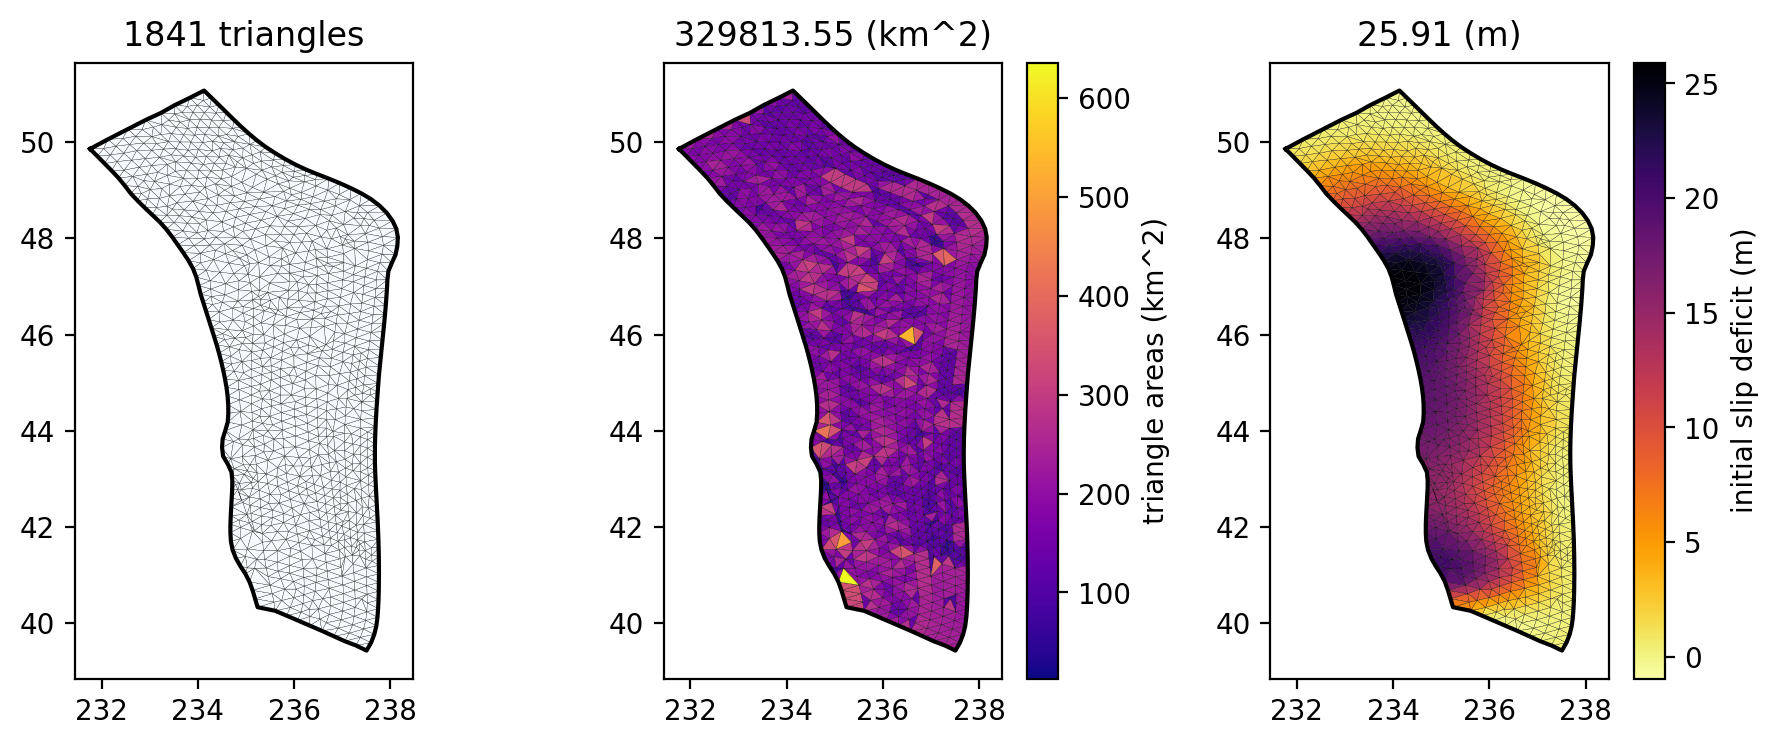

In [4]:
# Set initial conditions with accumulated slip
sources = addict.Dict()
sources.lon = np.array([235.779])
sources.lat = np.array([45.553])
sources.magnitude = np.array([10.0])
sources.slip_type = ["dip_slip"]
initial_slip_deficit = skies.get_synthetic_accumulated_slip(meshes[0], sources)
initial_dip_slip_deficit = initial_slip_deficit[1::2]

# Load initial slip defict and multiply by time cascadia_low_resolution_tde_dip_slip_rates.npy
initial_dip_slip_deficit = np.load("cascadia_low_resolution_tde_dip_slip_rates.npy")

total_coseismic_slip = np.zeros_like(initial_dip_slip_deficit)
skies.plot_initial_data(meshes, initial_dip_slip_deficit)


Target area is less than hypocenter triangle area
levels=array([0.1       , 0.10752436, 0.11504873, 0.12257309, 0.13009746,
       0.13762182, 0.14514619, 0.15267055, 0.16019492, 0.16771928])


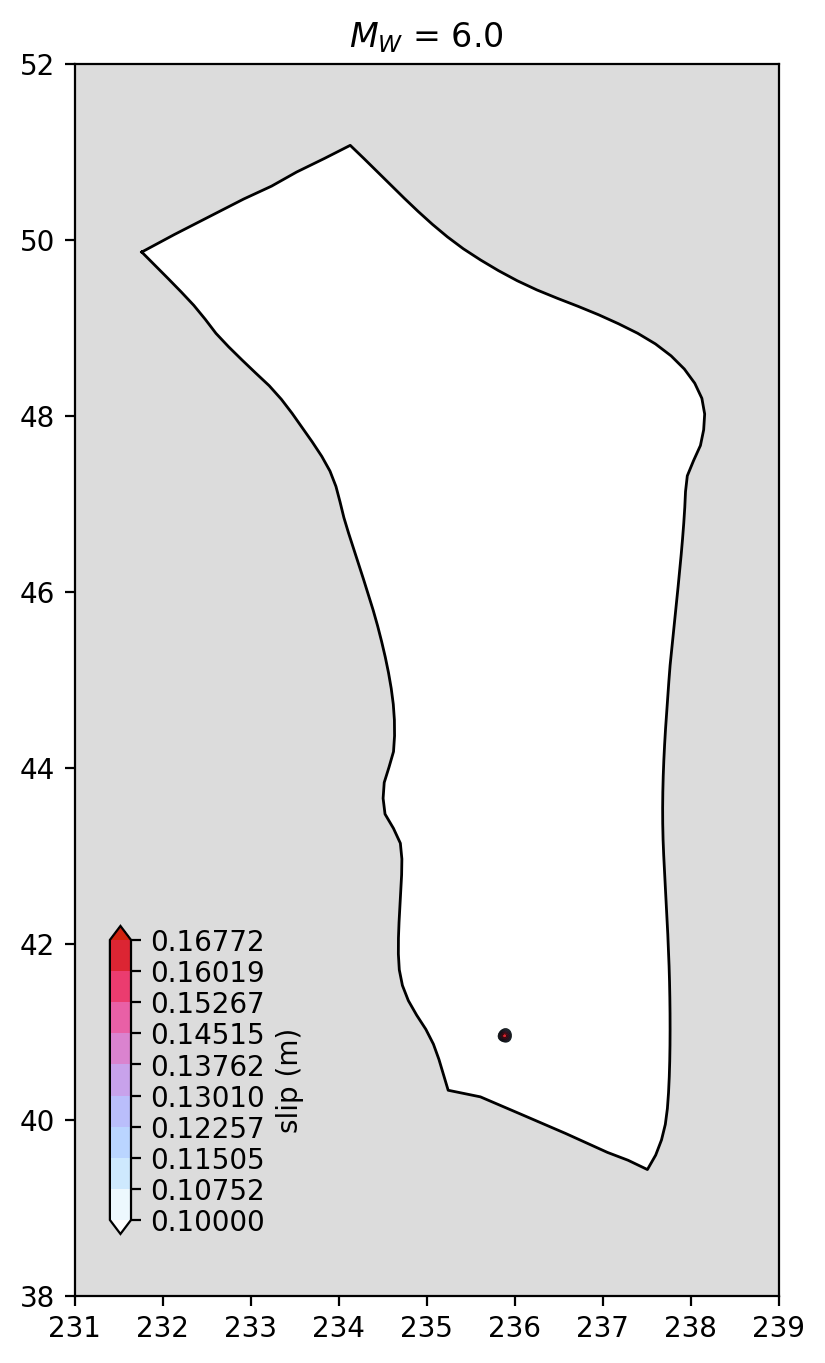

In [5]:
# Event basics
event = addict.Dict()
event.moment_magnitude = 6.0
event.hypocenter_longitude = 235.87495333  #  (degrees)
event.hypocenter_latitude = 40.94505867  #  (degrees)
event.hypocenter_depth = -15.36972933  # (km)
event.shear_modulus = 3e10
event.area_scaling = 1.25
# event = skies.get_event_area_slip_triangle_index(meshes[0], event)
event = skies.get_event_area_slip_hypocenter(meshes[0], event)

# Run parameters
params = addict.Dict()
params.n_grid_longitude = 1000
params.n_grid_latitude = 1000
params.min_longitude = 231.0
params.max_longitude = 239.0
params.min_latitude = 38.0
params.max_latitude = 52.0
params.n_contour_levels = 10
params.min_contour_value = 0.1  # (m)
params.savefig = True
params.run_name = run_name

# # Plot event eigenmodes
# skies.plot_event_select_eigenmodes(meshes[0], event, params)

# # Plot event slip
skies.quick_plot_slip(meshes[0], event, params)


In [6]:
np.random.seed(1)


def get_omori_decay_probability(time_vector, time_of_earthquake, amplitude, decay_time):
    omori_decay_probability = amplitude / (
        1 + (1 / decay_time) * (time_vector - time_of_earthquake)
    )

    omori_decay_probability[time_vector < time_of_earthquake] = 0.0
    return omori_decay_probability


MM2M = 1e-3  # millimeters to meters
SECONDS_IN_A_YEAR = 60 * 60 * 24 * 365
DAYS_IN_A_YEAR = 365
n_years = 100
time_vector = np.linspace(0, n_years, n_years * 1)
minimum_probability = 1e-5
time_probability = np.zeros_like(time_vector)
time_probability = minimum_probability * np.ones_like(time_vector)

# loading_rate = 30.0  # (mm/yr)
earthquake_index_list = []
earthquake_magnitude_list = []
earthquake_probability_list = []
event_trigger_list = []

b_value = -1.0
minimum_event_moment_magnitude = 7.0
maximum_event_moment_magnitude = 9.0

amplitude = 0.01

# Initial conditions
pre_event_slip_deficit = np.copy(initial_dip_slip_deficit)
total_slip_deficit = 1e-1 * np.copy(initial_dip_slip_deficit)
total_slip_deficit_scalar = np.zeros_like(time_vector)
total_slip_deficit_scalar[0] = np.sum(total_slip_deficit)

# Intial geometric moment deficit and storage
total_geometric_moment_deficit = initial_dip_slip_deficit * meshes[0].areas
total_geometric_moment_deficit_scalar = np.zeros_like(time_vector)
total_geometric_moment_deficit_scalar[0] = np.sum(
    initial_dip_slip_deficit * meshes[0].areas
)

time_step = 1e-6
interseismic_loading_rate = initial_dip_slip_deficit
time_probability_step = 0.00005
time_probability_step = 1e-10

candidate_event = addict.Dict()

# Main time loop
for i in range(0, len(time_vector) - 1):

    # Determine whether there is an event at this time step
    event_trigger = np.random.choice(
        2, 1, p=[1 - time_probability[i], time_probability[i]]
    )
    event_trigger_list.append(event_trigger)

    # Magnitude of candidate earthquake
    candidate_event.moment_magnitude = skies.get_gutenberg_richter_magnitude(
        b_value, minimum_event_moment_magnitude, maximum_event_moment_magnitude
    )

    # Do we have enough stored moment for a candidate event of this size
    # Candidate event moment and geometric moment
    AREA_SCALING = 1.25
    candidate_event.moment = 10 ** (
        1.5 * (candidate_event.moment_magnitude + 10.7) - 7.0
    )
    SHEAR_MODULUS = 3e10
    candidate_event.geometric_moment = candidate_event.moment / SHEAR_MODULUS
    if candidate_event.geometric_moment < total_geometric_moment_deficit_scalar[i]:
        geometric_moment_condition = True
    else:
        geometric_moment_condition = False
        print(f"Geometric moment conditions fails at: {i=}")

    # Do we have an earthquake at this time step?
    if bool(event_trigger) and (np.sum(total_slip_deficit) > 0):
        print(f"Earthquake at time step: {i}")
        # Generate a synthetic earthquake
        location_probability = skies.get_location_probability(pre_event_slip_deficit)

        # TODO: Unbundle event creation
        # skies.create_event_target(meshes, magnitude, hypocenter_location)
        event = skies.create_event(meshes, location_probability)
        event.location_probability = location_probability
        event.pre_event_slip_deficit = pre_event_slip_deficit
        event.post_event_slip_deficit = pre_event_slip_deficit - event.slip_all_elements

        earthquake_magnitude_list.append(event.moment_magnitude)
        earthquake_index_list.append(i)
        earthquake_probability_list.append(
            get_omori_decay_probability(
                time_vector, time_vector[i], amplitude, decay_time=100.0
            )
        )
        event.magnitude_dependent_amplitude = (
            amplitude + amplitude * event.moment_magnitude / 500
        )

        # Update the total slip deficit mesh
        total_slip_deficit = (
            total_slip_deficit
            + time_step * interseismic_loading_rate
            - event.slip_all_elements
        )

        # Update probability for event occurrence at the next time step
        time_probability[i + 1] = (
            time_probability[i] + time_step + event.magnitude_dependent_amplitude
        )

        # Save event dictionary as pickle file
        event_pickle_file_name = f"{output_path}/event_{i:010.0f}.pickle"
        with open(event_pickle_file_name, "wb") as pickle_file:
            pickle.dump(event, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

    else:
        # Update total_slip_deficit for the case when there are no earthquakes
        total_slip_deficit = total_slip_deficit + time_step * interseismic_loading_rate

        # Update time probability for event occurence at the next time step
        time_probability[i + 1] = time_probability[i] + time_step * np.sum(
            interseismic_loading_rate
        )

        # Sum contribution from all past earthquakes
        # TODO: The scaling factor here is magic
        for j in range(len(earthquake_index_list)):
            time_probability[i + 1] += 1.5 * (
                earthquake_probability_list[j][i + 1]
                - earthquake_probability_list[j][i]
            )

    total_geometric_moment_deficit_scalar[i + 1] = np.sum(
        total_slip_deficit * meshes[0].areas
    )

    # Update the total slip deficit scalar
    total_slip_deficit_scalar[i + 1] = np.sum(total_slip_deficit)

    # Pre-event slip deficit for next time step
    pre_event_slip_deficit = np.copy(total_slip_deficit)

    # Catch probabilities less than zero
    if time_probability[i + 1] < minimum_probability:
        time_probability[i + 1] = minimum_probability
        print(f"time_probability < 0.0 at step {i}")

    # Catch probabilities greater than one
    if time_probability[i + 1] >= 1.0:
        time_probability[i + 1] = 1.0
        print(f"time_probability > 1.0 at step {i}")

print(np.where(np.array(event_trigger_list) == 1)[0])


Earthquake at time step: 13
Earthquake at time step: 23
Earthquake at time step: 24
Earthquake at time step: 25
Earthquake at time step: 26
Earthquake at time step: 30
Earthquake at time step: 33
Earthquake at time step: 34
Earthquake at time step: 36
Earthquake at time step: 37
Geometric moment conditions fails at: i=38
Geometric moment conditions fails at: i=39
Geometric moment conditions fails at: i=40
Geometric moment conditions fails at: i=41
Geometric moment conditions fails at: i=42
Geometric moment conditions fails at: i=43
Geometric moment conditions fails at: i=44
Geometric moment conditions fails at: i=45
Geometric moment conditions fails at: i=46
Geometric moment conditions fails at: i=47
Geometric moment conditions fails at: i=48
Geometric moment conditions fails at: i=49
Geometric moment conditions fails at: i=50
Geometric moment conditions fails at: i=51
Geometric moment conditions fails at: i=52
Geometric moment conditions fails at: i=53
Geometric moment conditions fail

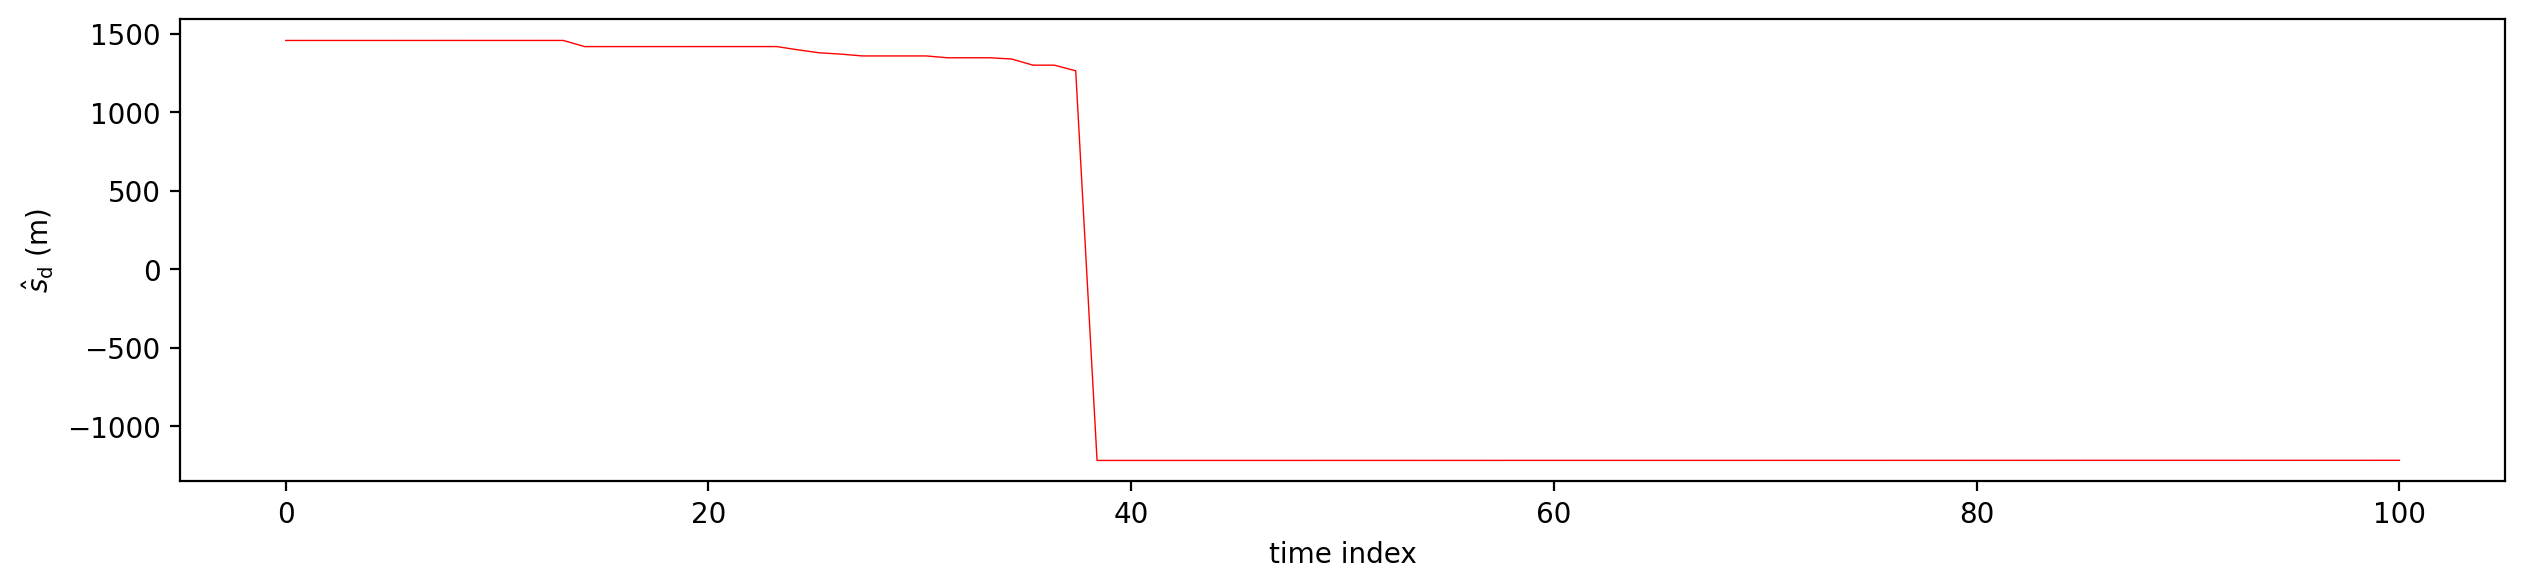

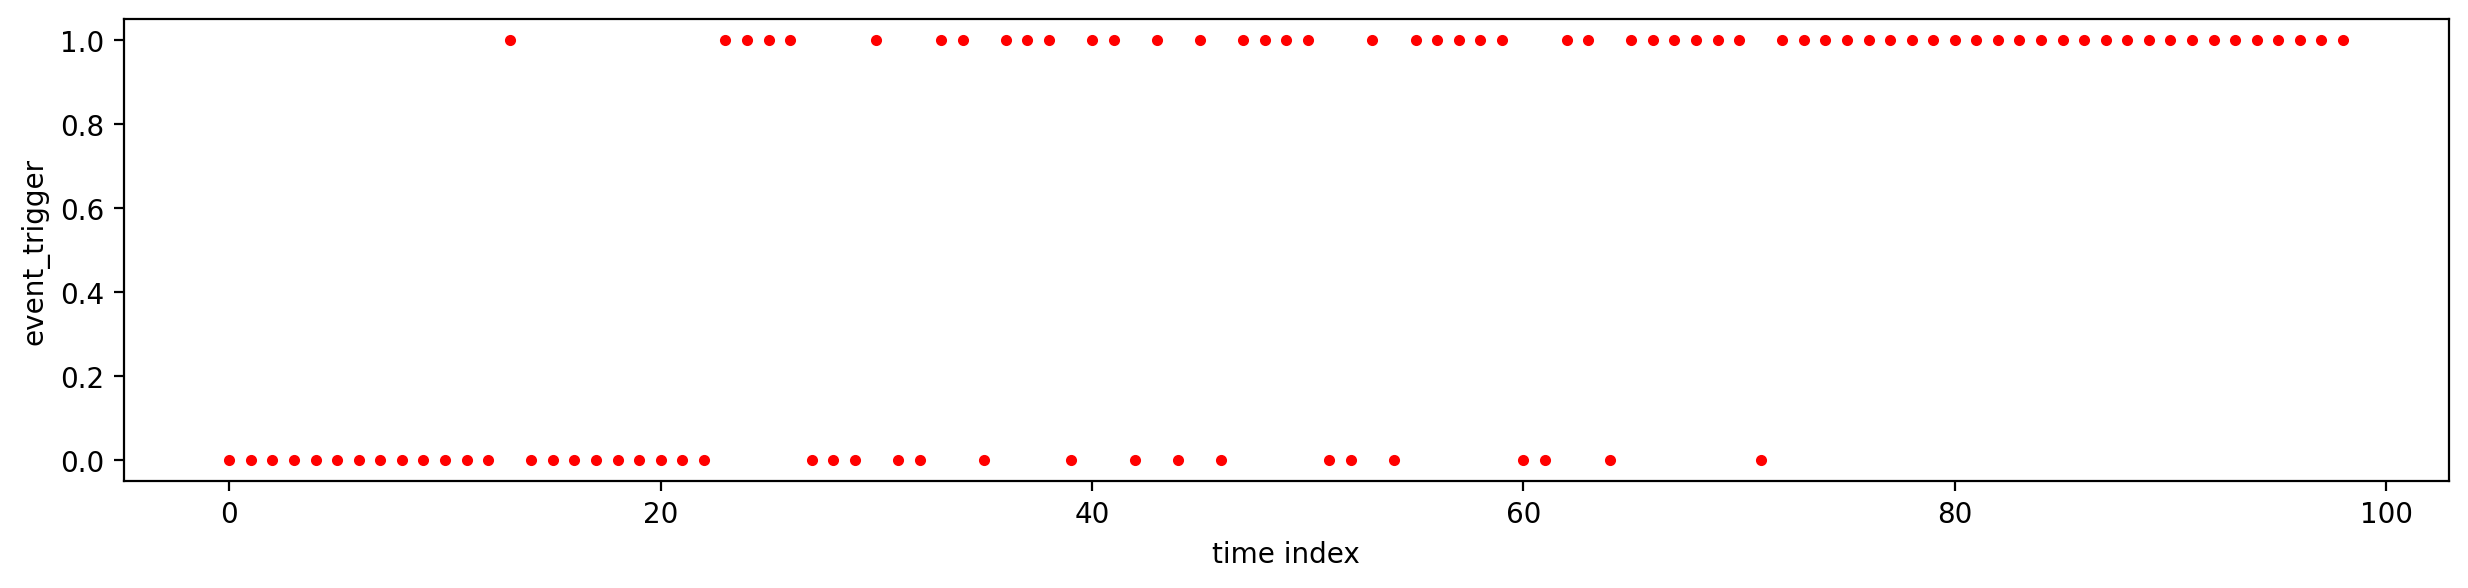

In [7]:
start_idx = 0
end_idx = 400000
figsize = (15, 3)

plt.figure(figsize=figsize)
# plt.plot(
#     [np.min(time_vector[start_idx:end_idx]), np.max(time_vector[start_idx:end_idx])],
#     [0, 0],
#     "-k",
#     linewidth=0.5,
# )
plt.plot(
    time_vector[start_idx:end_idx],
    total_slip_deficit_scalar[start_idx:end_idx],
    "-r",
    linewidth=0.5,
)
plt.xlabel("time index")
plt.ylabel("$\hat{s}_\mathrm{d}$ (m)")
# plt.xlim([np.min(time_vector), np.max(time_vector)])
# plt.ylim([1e-4, 1])


plt.figure(figsize=figsize)
plt.plot(event_trigger_list[start_idx:end_idx], "r.")
plt.xlabel("time index")
plt.ylabel("event_trigger")
plt.show()


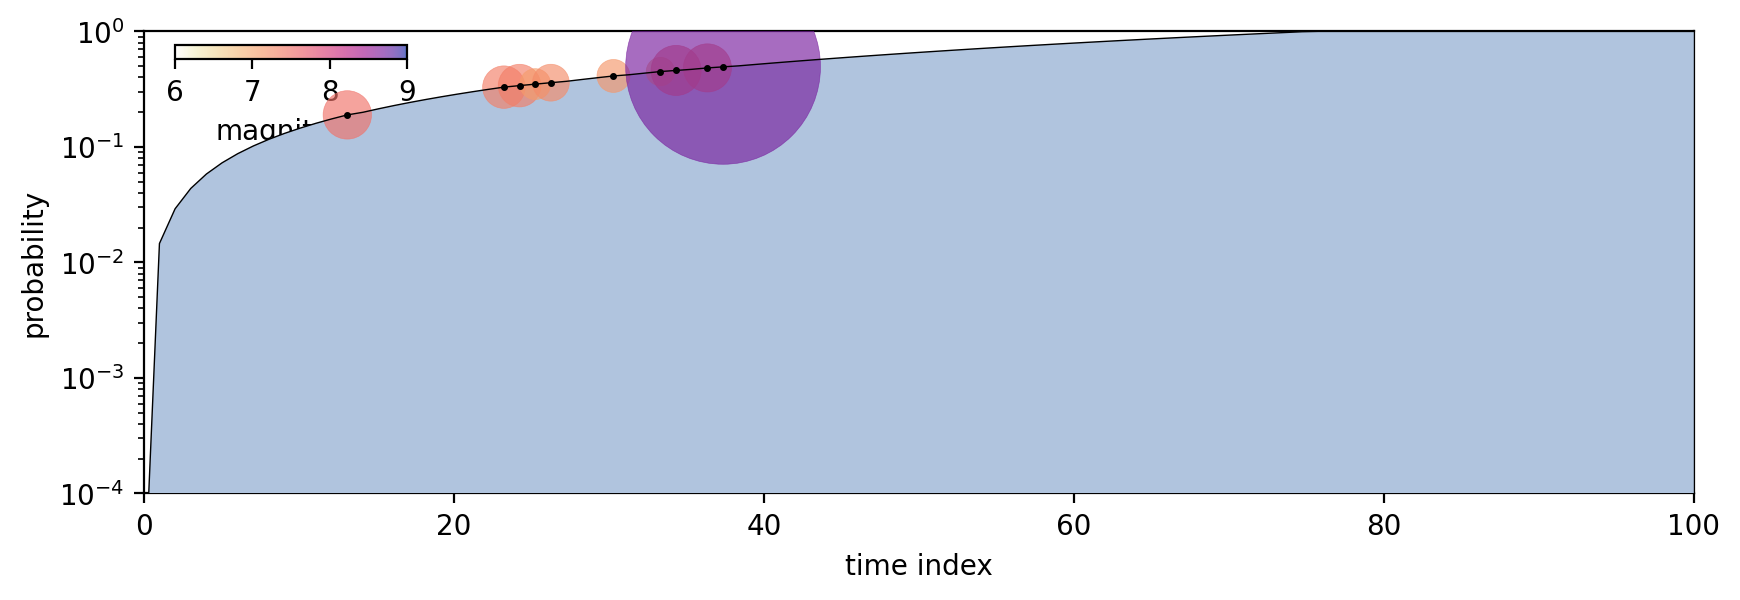

/Users/meade/mambaforge/envs/skies/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


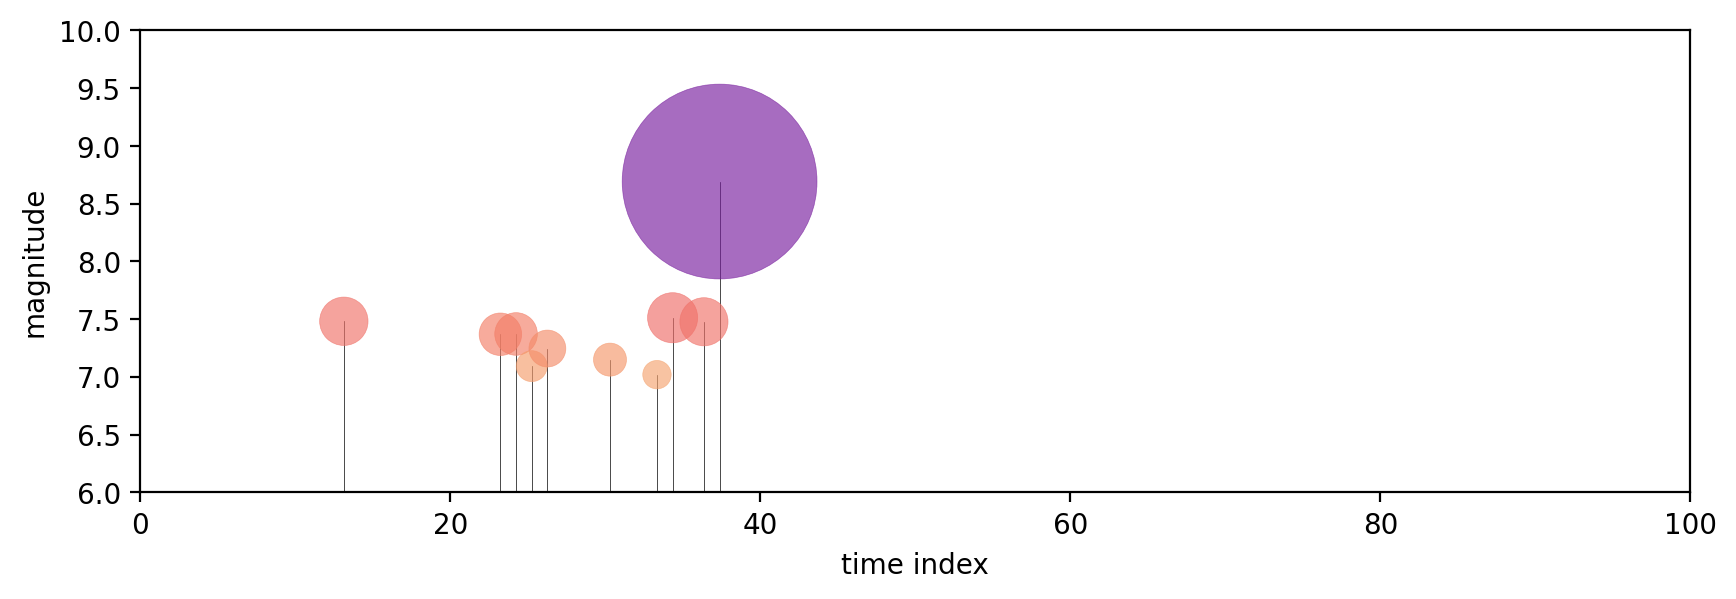

In [8]:
# Probability in time: Semilogy plot
plt.figure(figsize=(10, 3))
plt.semilogy(time_vector, time_probability, "-k", linewidth=0.5, zorder=35)
fill_x = np.append(time_vector, np.array([np.max(time_vector), 0]))
fill_y = np.append(
    time_probability, np.array([minimum_probability, minimum_probability])
)
plt.fill(
    fill_x,
    fill_y,
    color="lightsteelblue",
    alpha=1.0,
    edgecolor=None,
    zorder=10,
)

cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** np.array(earthquake_magnitude_list)
plt.scatter(
    time_vector[earthquake_index_list],
    time_probability[earthquake_index_list],
    s=magnitude_plot_size,
    c=earthquake_magnitude_list,
    zorder=20,
    alpha=0.65,
    cmap=cmap,
    edgecolors=None,
    linewidths=0.25,
    vmin=6.0,
    vmax=9.0,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.02, 0.94, 0.15, 0.03)),
    label="magnitude",
    orientation="horizontal",
    ticks=[6, 7, 8, 9],
)
cb.ax.tick_params(labelsize=10)

plt.plot(
    time_vector[earthquake_index_list],
    time_probability[earthquake_index_list],
    ".k",
    markersize=3,
    zorder=50,
)

plt.xlabel("time index")
plt.ylabel("probability")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([1e-4, 1])
# plt.savefig("example_probability_time_series_semilogy.pdf")
# plt.savefig("example_probability_time_series_semilogy.png", dpi=500)
plt.show()

# Earthquake magnitude plot
plt.figure(figsize=(10, 3))
for i in range(len(earthquake_index_list)):
    plt.plot(
        [time_vector[earthquake_index_list[i]], time_vector[earthquake_index_list[i]]],
        [6.0, earthquake_magnitude_list[i]],
        "-",
        # markersize=10**(earthquake_magnitude_list[i] - 6),
        linewidth=0.25,
        zorder=10,
        color="k",
    )


cmap = cc.cm.CET_L17
magnitude_plot_size = 1e-5 * 10 ** np.array(earthquake_magnitude_list)
plt.scatter(
    time_vector[earthquake_index_list],
    earthquake_magnitude_list,
    s=magnitude_plot_size,
    c=earthquake_magnitude_list,
    zorder=20,
    alpha=0.65,
    cmap=cmap,
    edgecolors=None,
    linewidths=0.25,
    vmin=6.0,
    vmax=9.0,
)

# for i in range(len(earthquake_index_list)):
#     plt.plot(
#         time_vector[earthquake_index_list[i]],
#         earthquake_magnitude_list[i],
#         ".",
#         markersize=10 ** (earthquake_magnitude_list[i] - 6),
#         # markersize=10,
#         alpha=1.0,
#         linewidth=0.0,
#         zorder=20,
#         color="orange",
#         markeredgecolor="k",
#         markeredgewidth=0.25,
#     )
plt.xlabel("time index")
plt.ylabel("magnitude")
plt.xlim([np.min(time_vector), np.max(time_vector)])
plt.ylim([6, 10])
# plt.grid(True, linewidth=0.5, linestyle="--")

# plt.savefig("example_magnitude_time_series_semilogy.pdf")
# plt.savefig("example_magnitude_time_series_semilogy.png", dpi=500)
plt.show()


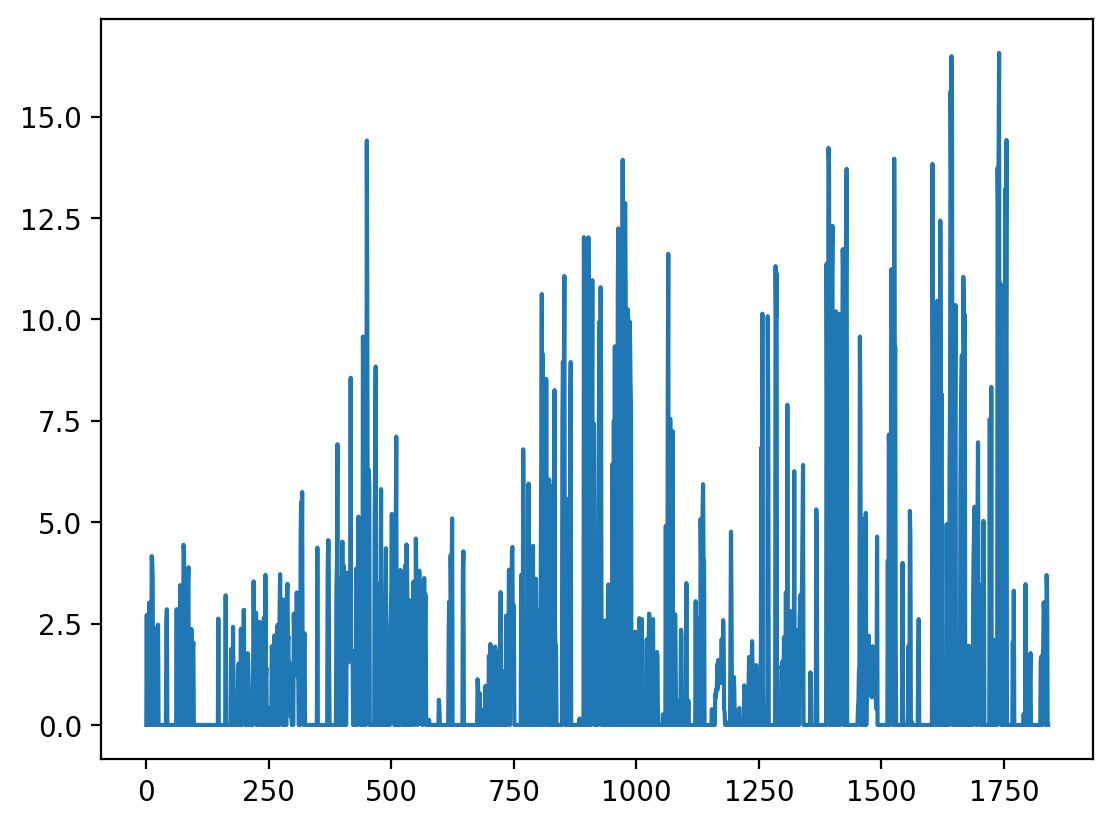

In [9]:
plt.plot(event.slip_all_elements)

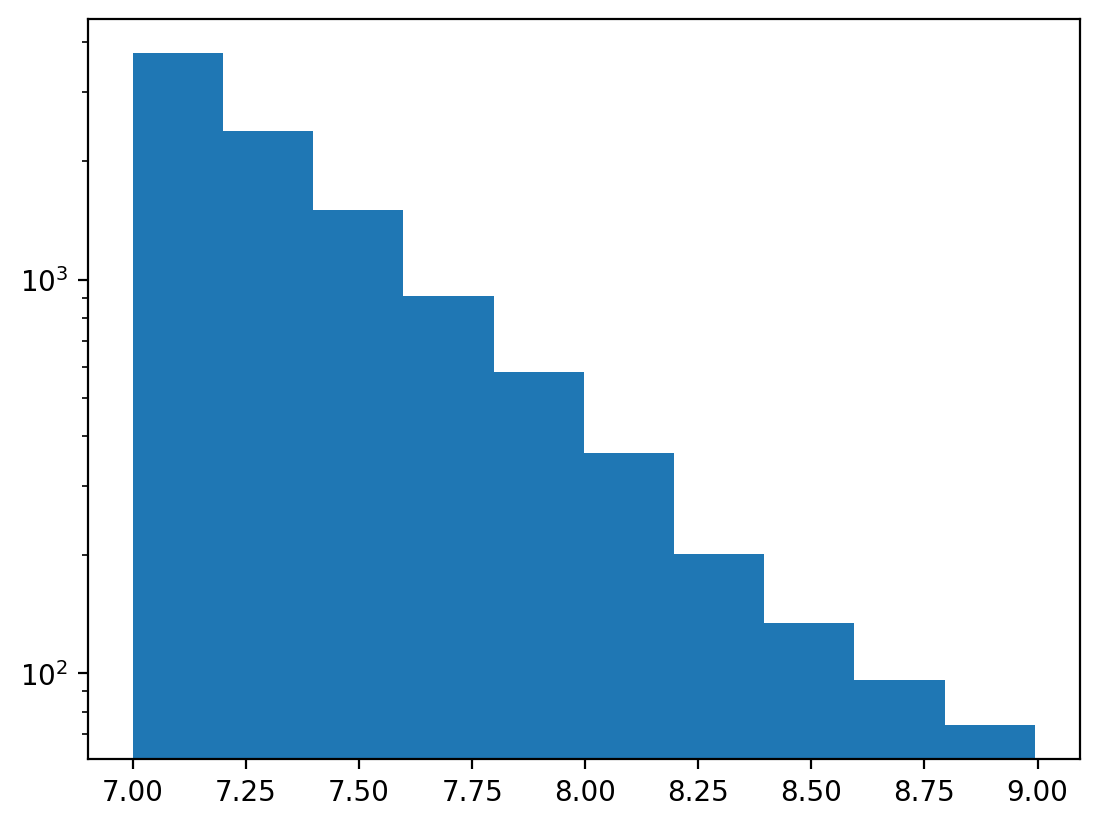

In [10]:
b_value = -1.0
minimum_event_moment_magnitude = 7.0
maximum_event_moment_magnitude = 9.0
n = 10000
temp = np.zeros(n)

for i in range(n):
    temp[i] = skies.get_gutenberg_richter_magnitude(
        b_value, minimum_event_moment_magnitude, maximum_event_moment_magnitude
    )
plt.figure()
plt.hist(temp, log=True)
plt.show()
